## Preparar el entorno

In [8]:
!pip install -r requirements_ejercicio1.txt

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mlflow
import mlflow.sklearn

from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split

import utils  # archivo en ../src/utils.py
from preprocessing import preprocess_text  # archivo en ../src/preprocessing.py
from train_model import *  # archivo en ../src/train_model.py

from pyngrok import ngrok
import mlflow
from mlflow.tracking import MlflowClient

## Carga de datos

In [26]:
categories = ['alt.atheism', 'rec.sport.baseball', 'comp.graphics', 'sci.space', 'sci.med']   # Elegimos estas categorías para la práctica
newsgroups_train = fetch_20newsgroups(subset='train', categories=categories, remove=('headers', 'footers', 'quotes'))
data = pd.DataFrame({'text': newsgroups_train.data, 'target': newsgroups_train.target})

In [11]:
data.head()

,text,target
0,\nYou can probably get this information by cal...,3
1,\nYou are making precisely one of the points I...,3
2,\nI could give much the same testimonial about...,0
3,"\n \nNo, the argument says John has known Q, ...",0
4,\nWas that post for real? I thought it was a l...,4


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2848 entries, 0 to 2847
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2848 non-null   object
 1   target  2848 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 44.6+ KB


In [8]:
data.isnull().sum()  # Debe dar 0 para todas las columnas si no hay NaN

text      0
target    0
dtype: int64

## Eliminar valores nulos

En este ejemplo no hay valores nulos en el dataset pero si los hubiera haríamos:

In [29]:
data = data.dropna(subset=['text', 'target'])

## Balancear las clases

In [27]:
min_count = data['target'].value_counts().min()
print(f"Número mínimo de registros presentes en las clases del target: {min_count}")

Número mínimo de registros presentes en las clases del target: 480


In [28]:
dfs = [] # Lista para almacenar los DataFrames temporales

for target in data['target'].unique():
    dfs.append(data[data['target'] == target].sample(min_count, random_state=42))

# Crear un DataFrame balanceado concatenando la lista de DataFrames
df_balanced = pd.concat(dfs, ignore_index=True)

In [41]:
df_balanced['target'].value_counts()

3    480
0    480
4    480
2    480
1    480
Name: target, dtype: int64

In [42]:
df_balanced.isnull().sum()

text      0
target    0
dtype: int64

In [29]:
df = df_balanced

## Guardar el dataframe balanceado

In [62]:
df_balanced.to_json('df_balanced.json', orient='records', lines=True)

In [36]:
df = pd.read_json('df_balanced.json', orient='records', lines=True)  # cargar los datos (archivo en ../data/df_balanced.csv)

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    2351 non-null   object
 1   target  2400 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


## División en conjuntos de entrenamiento, validación y prueba

In [30]:
train, test = train_test_split(df, test_size=0.2, random_state=42, stratify=df['target'])

# División en subconjuntos de entrenamiento y validación
x_train, x_val, y_train, y_val = train_test_split(
    train[['text']],
    train['target'],
    test_size=0.2,
    random_state=42,
    stratify=train['target']  # Distribución equitativa de las clases
)

In [31]:
print(train.shape, test.shape)
print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
print(np.bincount(y_train), np.bincount(y_val))

(1920, 2) (480, 2)
(1536, 1) (384, 1) (1536,) (384,)
[307 308 307 307 307] [77 76 77 77 77]


In [46]:
print(type(x_train))
print(x_train.head())

<class 'pandas.core.frame.DataFrame'>
                                                   text
1743  \nOh... I forgot... Art Shamsky, former Red an...
2060  Hi,\n\nI've noticed that if you only save a mo...
2300  \nThere are 2 books published by M&T BOOKS tha...
2031  Does anybody know where I can get, via anonymo...
1289  Sorry for asking a question that's not entirel...


In [47]:
x_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1536 entries, 1743 to 800
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1536 non-null   object
dtypes: object(1)
memory usage: 24.0+ KB


## Preparación del Conjunto de Prueba

Extraemos la variable objetivo del conjunto de prueba y la guardamos en un archivo CSV. Después, eliminamos la variable objetivo del conjunto de prueba y la guardamos en otro archivo CSV:

In [75]:
test_target = test['target']
test_target.to_csv('test-target.csv', index=False)
test.drop(columns=['target']).to_json('test.json', orient='records', lines=True)

## Función de preprocesado de texto

Implementamos una función de preprocesado de texto que nos permitirá estandarizar el formado de los textos y reducir la cardinalidad del vocabulario. Se realizan los siguientes pasos:

- Eliminar tildes
- Eliminar símbolos
- Eliminar todo carácter que no sea una letra
- Eliminar stopwords
- Lemmatización en base a diccionario de token-lemma

### Verificación del Preprocesamiento

Seleccionamos un texto aleatorio para mostrar antes y después del preprocesamiento:

In [49]:
texto_crudo = x_train['text'].sample(random_state=20).iloc[0]
texto_preprocesado = preprocess_text(texto_crudo)

print("Texto Crudo:\n", texto_crudo)
print("\nTexto Preprocesado:\n", texto_preprocesado)

Texto Crudo:
 My god, hope we don't have to put up with this kind of junk all season!


How many home runs by Tartabull?  Just 1, right, you must be thinking
of Dean Palmer or Juan Gonzalez (both of Texas) who each had 2 homers.


I don't know how many to follow, but he was 1 for 4.


Texto Preprocesado:
 god hope dont put kind junk season many home run tartabull right must thinking dean palmer juan gonzalez texas homer dont know many follow


### Aplicar preprocesamiento

In [32]:
x_train['text'] = x_train['text'].apply(preprocess_text)
x_val['text'] = x_val['text'].apply(preprocess_text)
test['text'] = test['text'].apply(preprocess_text)

In [33]:
x_train['text'].head()

1743    oh forgot art shamsky former red mets player b...
2060    hi ive noticed save model mapping plane positi...
2300    book published mt book come c source code flop...
2031    anybody know get via anonymous ftp otherwise p...
1289    sorry asking question thats entirely based tec...
Name: text, dtype: object

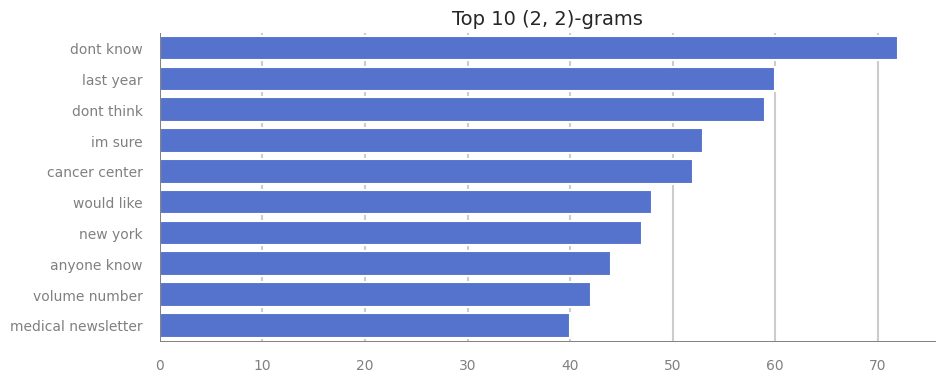

In [52]:
# Visualizar los top 10 bigrams
utils.plot_top_ngrams(x_train['text'], n=10, ngrams=(2,2))

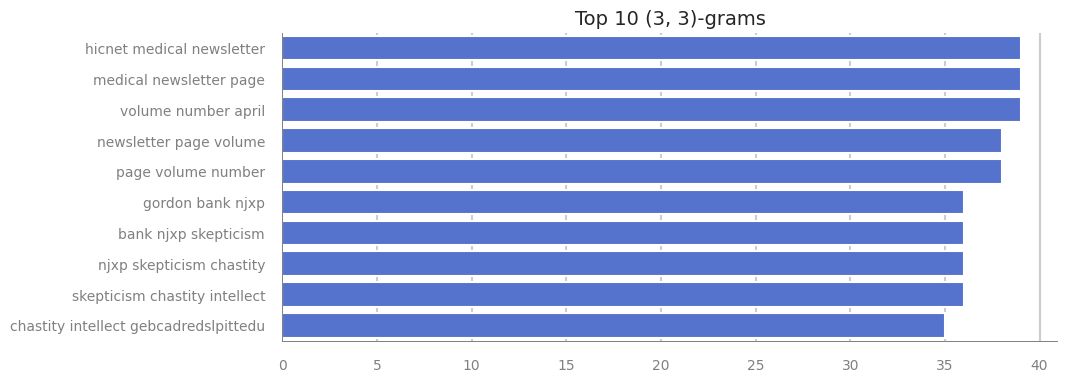

In [53]:
# Visualizar los top 10 trigrams
utils.plot_top_ngrams(x_train['text'], n=10, ngrams=(3,3))

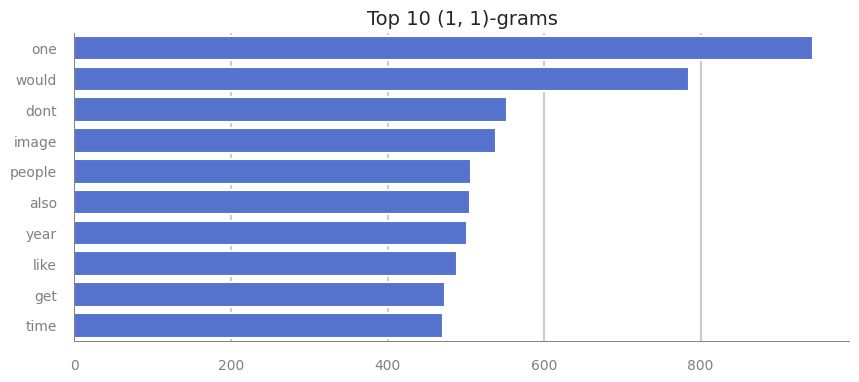

In [54]:
utils.plot_top_ngrams(x_train['text'], n=10)

### Observar valores nulos tras el preprocesamiento de los textos

In [64]:
print(f"Valores nulos en train: {x_train['text'].isnull().sum()}")
print(f"Valores nulos en val: {x_val['text'].isnull().sum()}")
print(f"Valores nulos en test: {test['text'].isnull().sum()}")

Valores nulos en train: 0
Valores nulos en val: 0
Valores nulos en test: 0


### Guardar los datos preprocesados

In [31]:
"""
x_train.to_csv('train_processed.csv', index=False)
x_val.to_csv('val_processed.csv', index=False)
test.to_csv('test_processed.csv', index=False)
"""

In [73]:
x_train.to_json('train_processed.json', orient='records', lines=True)
x_val.to_json('val_processed.json', orient='records', lines=True)
test.to_json('test_processed.json', orient='records', lines=True)

Nota: Optamos por guardar los archivos en formato JSON en lugar de CSV debido a la naturaleza de los datos textuales en el proyecto. Los textos pueden incluir caracteres especiales, como comas y saltos de línea, que complican su manejo en el formato CSV, ya que estos caracteres pueden interpretarse erróneamente como delimitadores de campo o registro. El formato JSON maneja de manera nativa estos caracteres especiales y preserva la integridad del texto, asegurando que los datos se guarden y carguen exactamente como se pretende, sin pérdida de información ni malinterpretación de la estructura de los datos.

## Entrenar el modelo

In [56]:
best_model = train_and_tune(x_train['text'], y_train)

Mejores parámetros encontrados:
{'clf__class_weight': 'balanced', 'clf__min_samples_leaf': 2, 'clf__n_estimators': 200}


## Entrenar y evaluar el modelo

              precision    recall  f1-score   support

           0       0.78      0.83      0.81        77
           1       0.80      0.87      0.84        76
           2       0.77      0.91      0.83        77
           3       0.92      0.71      0.80        77
           4       0.84      0.75      0.79        77

    accuracy                           0.82       384
   macro avg       0.82      0.82      0.81       384
weighted avg       0.82      0.82      0.81       384



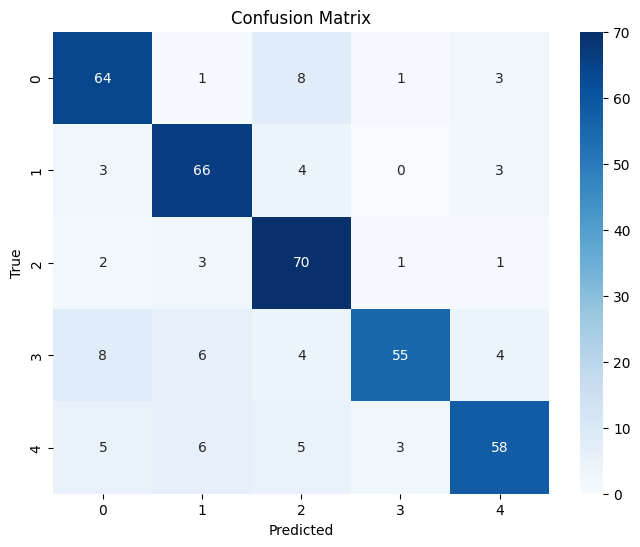

In [34]:
results = train_and_evaluate(x_train['text'], y_train, x_val['text'], y_val)

In [35]:
model = results['model']

In [36]:
accuracy_train = results['accuracy']
f1_score_train = results['f1_score']

print(f"Accuracy: {accuracy_train}")
print(f"F1 Score: {f1_score_train}")

Accuracy: 0.8151041666666666
F1 Score: 0.8141944235583839


### Características más importantes

In [61]:
feature_names = model.named_steps['tfidf'].get_feature_names_out()
feature_importances = model.named_steps['clf'].feature_importances_

# Obtener las características más importantes
sorted_indices = feature_importances.argsort()[::-1]

for i in sorted_indices[:20]:  # Podemos cambiar el 20 por el número de top características que queramos mostrar
    print(f"{feature_names[i]}: {feature_importances[i]}")

space: 0.022220304570779656
game: 0.016204681417275865
graphic: 0.014144797808726555
file: 0.012465300319678909
god: 0.010956421507647163
baseball: 0.010824448011011538
team: 0.009413764321384016
image: 0.009100367956293785
player: 0.008740409842780288
doctor: 0.00812977544073422
program: 0.007123656922945057
orbit: 0.006915352223054367
fan: 0.006723397230099557
religion: 0.006198618041353984
people: 0.006182483987445936
patient: 0.006164224150010627
hit: 0.006135059758278459
disease: 0.006124494986556544
season: 0.006104799188275643
food: 0.006061916362657452


## Conclusiones

El modelo de clasificación **RandomForest** evaluado muestra un rendimiento equilibrado en términos de precisión, recall y puntaje F1 a través de las cinco clases del conjunto de validación.

La **precisión global** del modelo es del `81.5%`, con un **puntaje F1** ponderado similar, lo que indica una buena armonía entre la precisión y la exhaustividad en todas las clases.

La clase con **mejor recall es la clase 2** (`91%`), sugiriendo una alta capacidad del modelo para identificar esta clase correctamente. La **clase 3**, aunque tiene la precisión más alta (`92%`), exhibe el recall más bajo (`71%`), lo cual puede señalar una tendencia del modelo a ser más conservador al predecir esta clase, posiblemente debido a características distintivas aprendidas durante el entrenamiento.

La **matriz de confusión** proporciona una representación visual detallada de las predicciones del modelo frente a las etiquetas verdaderas, mostrando una distribución razonablemente uniforme de errores a través de las clases.

Los resultados indican un modelo robusto pero con espacio para mejora, especialmente en la optimización del recall para algunas clases.

# Registro y Despliegue del Modelo con MLflow

In [1]:
!pip install pyngrok

In [38]:
with mlflow.start_run(run_name='Clasificacion de Documentos'):
  mlflow.log_metric('accuracy', accuracy_train)
  mlflow.log_metric('f1_score', f1_score_train)
  mlflow.log_param('min_samples_leaf', 2)
  mlflow.log_param('n_estimators', 2)

get_ipython().system_raw('mlflow ui --port 5001 &')

ngrok.kill()

NGROK_AUTH_TOKEN = '2dsHDK18ycaK9u7xt3bjIrJEZCo_7LkMjXXuRT67o1JropNFR'
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

ngrok_tunnel = ngrok.connect(addr='5001', proto='http', bind_tls=True)
print('El tracking UI:', ngrok_tunnel.public_url)

El tracking UI: https://dde5-34-106-175-10.ngrok-free.app


In [39]:
client = MlflowClient()

In [40]:
model_name = 'clf-model'

In [41]:
with mlflow.start_run() as run:
  run_num = run.info.run_id
  model_uri = 'run:/{run_id}/artifact_path'.format(run_id=run_num, artifact_path=model_name)

  mlflow.log_metric('accuracy', accuracy_train)
  mlflow.sklearn.log_model(model,model_name)

  model_details = mlflow.register_model(
      model_uri = model_uri,
      name = model_name
  )

Registered model 'clf-model' already exists. Creating a new version of this model...
Created version '2' of model 'clf-model'.


In [46]:
model_version_infos = client.search_model_versions("name = '%s'" % model_name)

In [47]:
new_model_version = max([model_version_info.version for model_version_info in model_version_infos])

In [48]:
new_model_version

2

In [49]:
from mlflow.entities.model_registry.model_version_status import ModelVersionStatus

def wait_model_transition(model_name, model_version, stage):
  client = MlflowClient()
  for _ in range(10):
    model_version_details = client.get_model_version(
      name=model_name,
      version=model_version,
    )
    status = ModelVersionStatus.from_string(model_version_details.status)
    print("Model status: %s" % ModelVersionStatus.to_string(status))
    if status == ModelVersionStatus.READY:
      client.transition_model_version_stage(
          name=model_name,
          version=model_version,
          stage=stage,
        )
      break
    time.sleep(1)

In [50]:
try:
  wait_model_transition(model_name, int(new_model_version)-1, "None")
except:
  pass

wait_model_transition(model_name, new_model_version, "Staging")

Model status: READY
Model status: READY


<ipython-input-49-00287e974e80>:13: FutureWarning: ``mlflow.tracking.client.MlflowClient.transition_model_version_stage`` is deprecated since 2.9.0. Model registry stages will be removed in a future major release. To learn more about the deprecation of model registry stages, see our migration guide here: https://mlflow.org/docs/2.11.3/model-registry.html#migrating-from-stages
  client.transition_model_version_stage(


In [51]:
new_model_version

2

In [53]:
client.update_model_version(
  name=model_name,
  version=new_model_version,
  description="This model is a random forest classifier for the fetch_20newsgroups dataset from sklearn."
)

<ModelVersion: aliases=[], creation_timestamp=1712336644656, current_stage='Staging', description=('This model is a random forest classifier for the fetch_20newsgroups dataset '
 'from sklearn.'), last_updated_timestamp=1712337172551, name='clf-model', run_id=None, run_link=None, source='run:/c733cfbb77d4418ba0183983ad9cb232/artifact_path', status='READY', status_message=None, tags={}, user_id=None, version=2>